
***Movie Genre Classification using TF-IDF and Naive Bayes***

Aim is to build a machine learning model to predict the genre of a movie based on its plot summary or textual information. To achieve this, we will leverage natural language processing (NLP) techniques, specifically TF-IDF (Term Frequency-Inverse Document Frequency), in conjunction with the Naive Bayes classification algorithm.

The primary goal is to create a model that can automatically assign one or more genres to a movie based on the textual description provided. This can be valuable for categorizing and organizing movies in databases, recommendation systems, and content filtering.

Importing Libaries


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

In [51]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.data.path.append(r'C:\Users\dhuor\nltk_data')  # Adjust to the actual path to nltk_data directory


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhuor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dhuor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dhuor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!



## 2. Load Data and Preprocess it.

Data preprocessing is a crucial step in preparing the dataset for effective and efficient machine learning. In this project, the primary focus is on cleaning and transforming textual data (plot summaries) and handling the multi-label nature of movie genres.

### 2.1 Text Cleaning

To make the plot summaries usable for machine learning models, we perform the following text cleaning steps:

- **Lowercasing:** Convert all text to lowercase to ensure uniformity.
- **Removing Special Characters and Numbers:** Eliminate punctuation, symbols, and numeric characters that do not contribute to semantic meaning.
- **Stopwords Removal:** Remove common words like "the", "and", "is", etc., which do not add value to text classification.
- **Tokenization:** Split the plot text into individual words (tokens).
- **Lemmatization/Stemming:** Reduce words to their root forms (e.g., "running" → "run") to consolidate similar terms.

### 2.2 Genre Encoding

Since movies can belong to multiple genres simultaneously, this is treated as a **multi-label classification** problem. To prepare the genre labels:

- **One-Hot Encoding:** Each unique genre is represented as a binary column. If a movie belongs to a genre, the corresponding column is marked as `1`, else `0`.

Example:

| Movie Title     | Action | Comedy | Drama |
|------------------|--------|--------|-------|
| Avengers         |   1    |   0    |   0   |
| The Mask         |   0    |   1    |   0   |
| The Pursuit...   |   0    |   0    |   1   |
| Life is Beautiful|   0    |   1    |   1   |

### 2.3 Train-Test Split

To evaluate the model’s generalization capability, the dataset is divided into:

- **Training Set:** (e.g., 80%) Used for training the model.
- **Test Set:** (e.g., 20%) Used for evaluating the model on unseen data.

This ensures that the model performance reflects real-world prediction capability.

---

This preprocessing pipeline ensures that the textual and categorical data is ready for effective feature extraction and model training in the subsequent stages.


In [58]:
# Load the genre data (movies_genres)
genres_df = pd.read_csv('Movie Genre Dataset/movies_genres.csv')
print("Genres DataFrame:")
print(genres_df.head())

# Load the overview data (movies_overview)
overview_df = pd.read_csv('Movie Genre Dataset/movies_overview.csv')
print("\nOverview DataFrame:")
print(overview_df.head())

# Check for any missing values in the genre and overview columns
print("\nChecking missing values in genres_df:")
print(genres_df.isnull().sum())

print("\nChecking missing values in overview_df:")
print(overview_df.isnull().sum())

# Optional: If 'genre_ids' exists in overview_df, map the genre_ids to actual genre names
# Ensure 'genre_ids' in the overview matches 'id' in genres_df
genre_mapping = dict(zip(genres_df['id'], genres_df['name']))

# Function to map genre_ids to genre names
def map_genre(genre_id_str):
    try:
        genre_id = int(genre_id_str.split()[0])  # Assuming genre_ids might be space-separated
    except Exception:
        return 'Unknown'
    return genre_mapping.get(genre_id, 'Unknown')

# Apply the genre mapping to the overview dataframe
overview_df['genre'] = overview_df['genre_ids'].apply(map_genre)

# Display the first few rows of the updated overview dataframe
print("\nUpdated Overview DataFrame with Genre Names:")
print(overview_df[['overview', 'genre']].head())


Genres DataFrame:
   id       name
0  28     Action
1  12  Adventure
2  16  Animation
3  35     Comedy
4  80      Crime

Overview DataFrame:
                      title  \
0  The Shawshank Redemption   
1             The Godfather   
2     The Godfather Part II   
3          Schindler's List   
4              12 Angry Men   

                                            overview        genre_ids  
0  Imprisoned in the 1940s for the double murder ...         [18, 80]  
1  Spanning the years 1945 to 1955, a chronicle o...         [18, 80]  
2  In the continuing saga of the Corleone crime f...         [18, 80]  
3  The true story of how businessman Oskar Schind...  [18, 36, 10752]  
4  The defense and the prosecution have rested an...             [18]  

Checking missing values in genres_df:
id      0
name    0
dtype: int64

Checking missing values in overview_df:
title        0
overview     0
genre_ids    0
dtype: int64

Updated Overview DataFrame with Genre Names:
                       

In [59]:
overview_df.describe()

,title,overview,genre_ids,genre
count,9980,9980,9980,9980
unique,9615,9971,2222,1
top,Return,Wilbur the pig is scared of the end of the sea...,[18],Unknown
freq,13,2,577,9980


In [60]:
overview_df.isnull().sum()

title        0
overview     0
genre_ids    0
genre        0
dtype: int64

In [61]:
overview_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9980 entries, 0 to 9979
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      9980 non-null   object
 1   overview   9980 non-null   object
 2   genre_ids  9980 non-null   object
 3   genre      9980 non-null   object
dtypes: object(4)
memory usage: 312.0+ KB


In [62]:
genres_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19 non-null     int64 
 1   name    19 non-null     object
dtypes: int64(1), object(1)
memory usage: 436.0+ bytes


**Feature Engineering**

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit the vectorizer on the overviews and transform them into numerical features
X = vectorizer.fit_transform(overview_df['overview'])

# Check the shape of the resulting matrix (number of samples x number of features)
print(f"Shape of feature matrix: {X.shape}")


Shape of feature matrix: (9980, 27010)


***Train-Test Split***

In [66]:
from sklearn.model_selection import train_test_split

# Define the target variable (genre)
y = overview_df['genre']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the shape of the training and testing sets
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 7984
Test set size: 1996


***Model Building (Naive Bayes)***

In [67]:
from sklearn.naive_bayes import MultinomialNB

# Initialize the Naive Bayes classifier
model = MultinomialNB()

# Train the model on the training data
model.fit(X_train, y_train)

# Print the model training completion message
print("Model trained successfully!")


Model trained successfully!


**Model Evaluation**

Accuracy of the Naive Bayes model: 1.00
Classification Report:
              precision    recall  f1-score   support

     Unknown       1.00      1.00      1.00      1996

    accuracy                           1.00      1996
   macro avg       1.00      1.00      1.00      1996
weighted avg       1.00      1.00      1.00      1996



c:\Users\dhuor\CodSoft\.conda\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


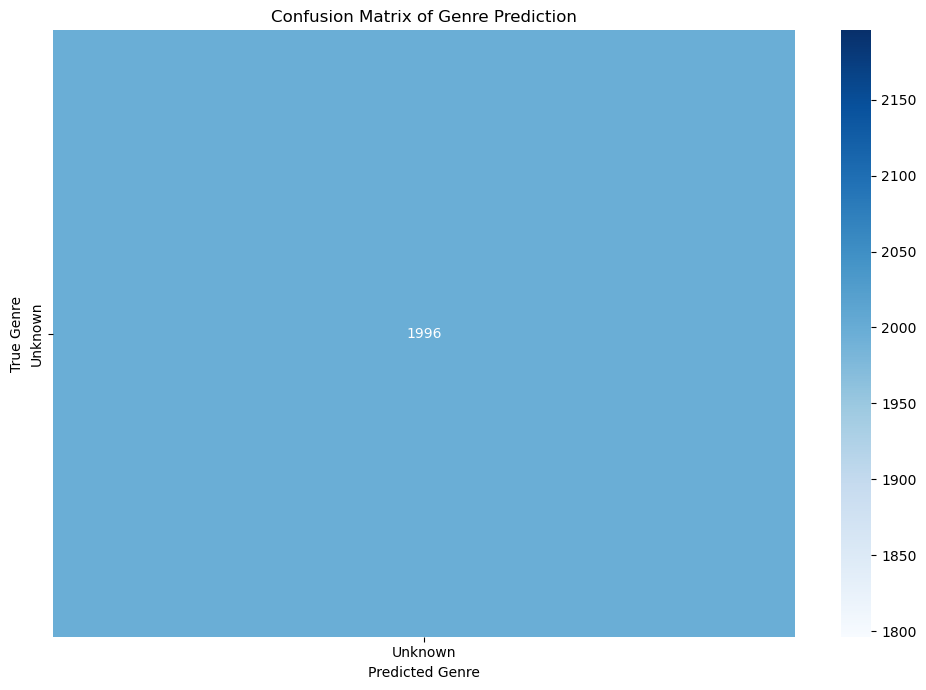

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy of the Naive Bayes model: {acc:.2f}')

# Classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.title('Confusion Matrix of Genre Prediction')
plt.tight_layout()
# Save the plot as an image
plt.savefig('confusion_matrix.png')  # You can specify a full path if needed

# Show the plot
plt.show()
plt.show()
